In [3]:
import pandas as pd
df = pd.read_excel('Online Retail.xlsx')

# rename columns for consistency
df.rename(columns={
    'InvoiceNo': 'invoice',
    'StockCode': 'stock_code',
    'InvoiceDate': 'invoice_date',
    'UnitPrice': 'price',
    'CustomerID': 'customer_id'
}, inplace=True)

# Drop rows with missing CustomerID
initial_rows = len(df)
df.dropna(subset=['customer_id'], inplace=True)
print(f"Number of rows before dropping NaNs: {initial_rows}")
print(f"Number of rows after dropping NaNs: {len(df)}")

# Remove cancelled orders
df = df[~df['invoice'].astype(str).str.startswith('C')]
print(f"Number of rows after removing cancellations: {len(df)}")

# Filter out invalid prices and quantities
df = df[(df['Quantity'] > 0) & (df['price'] > 0)]
print(f"Number of rows after filtering invalid values: {len(df)}")

# Convert invoice_date to datetime format
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

print("\n--- Cleaned Data Information ---")
print(df.info())

print("\n--- First 5 rows of the cleaned data ---")
print(df.head())

Number of rows before dropping NaNs: 541909
Number of rows after dropping NaNs: 406829
Number of rows after removing cancellations: 397924
Number of rows after filtering invalid values: 397884

--- Cleaned Data Information ---
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice       397884 non-null  object        
 1   stock_code    397884 non-null  object        
 2   Description   397884 non-null  object        
 3   Quantity      397884 non-null  int64         
 4   invoice_date  397884 non-null  datetime64[ns]
 5   price         397884 non-null  float64       
 6   customer_id   397884 non-null  float64       
 7   Country       397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB
None

--- First 5 rows of the cleaned data ---
  invoice stock_code         

In [4]:
import pandas as pd
from datetime import timedelta, datetime
df = pd.read_excel('Online Retail.xlsx')
df.columns = df.columns.str.lower()
df.rename(columns={'invoiceno': 'invoice_no', 'stockcode': 'stock_code',
                       'invoicedate': 'invoice_date', 'unitprice': 'price',
                       'customerid': 'customer_id'}, inplace=True)
df.dropna(subset=['customer_id'], inplace=True)
df['customer_id'] = df['customer_id'].astype(int)
df = df[~df['invoice_no'].astype(str).str.startswith('C')]
df = df[(df['quantity'] > 0) & (df['price'] > 0)]
df['invoice_date'] = pd.to_datetime(df['invoice_date'])
df.sort_values('invoice_date', inplace=True)

# 'total_spend' for each transaction
df['total_spend'] = df['quantity'] * df['price']

# a reference date for Recency calculation. 2e use the day after the last transaction.
reference_date = df['invoice_date'].max() + timedelta(days=1)

# group by 'customer_id' to compute RFM and other features
customer_data = df.groupby('customer_id').agg(
    # recency: Days since the last purchase
    recency=('invoice_date', lambda x: (reference_date - x.max()).days),

    # frequency: Number of unique invoices
    frequency=('invoice_no', 'nunique'),

    # monetary: Total spend
    monetary=('total_spend', 'sum'),

    # other useful features
    avg_order_value=('total_spend', 'mean'),
    avg_items_per_order=('quantity', 'mean')
).reset_index()

# handle cases where customers only have one order and no `days_between_orders` can be calculated
customer_data['days_between_orders'] = df.groupby('customer_id')['invoice_date'].apply(
    lambda x: (x.diff().dropna().mean()).days
)
customer_data['days_between_orders'].fillna(0, inplace=True)

# display the new customer-level DataFrame
print("\n--- RFM and Customer-level Features ---")
print(customer_data.head())
print(customer_data.describe())


--- RFM and Customer-level Features ---
   customer_id  recency  frequency  monetary  avg_order_value  \
0        12346      326          1  77183.60     77183.600000   
1        12347        2          7   4310.00        23.681319   
2        12348       75          4   1797.24        57.975484   
3        12349       19          1   1757.55        24.076027   
4        12350      310          1    334.40        19.670588   

   avg_items_per_order  days_between_orders  
0         74215.000000                  0.0  
1            13.505495                  0.0  
2            75.516129                  0.0  
3             8.643836                  0.0  
4            11.588235                  0.0  
        customer_id      recency    frequency       monetary  avg_order_value  \
count   4338.000000  4338.000000  4338.000000    4338.000000      4338.000000   
mean   15300.408022    92.536422     4.272015    2054.266460        68.350506   
std     1721.808492   100.014169     7.697998    

/tmp/ipython-input-1785023772.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data['days_between_orders'].fillna(0, inplace=True)


/tmp/ipython-input-2745791288.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data['days_between_orders'].fillna(0, inplace=True)


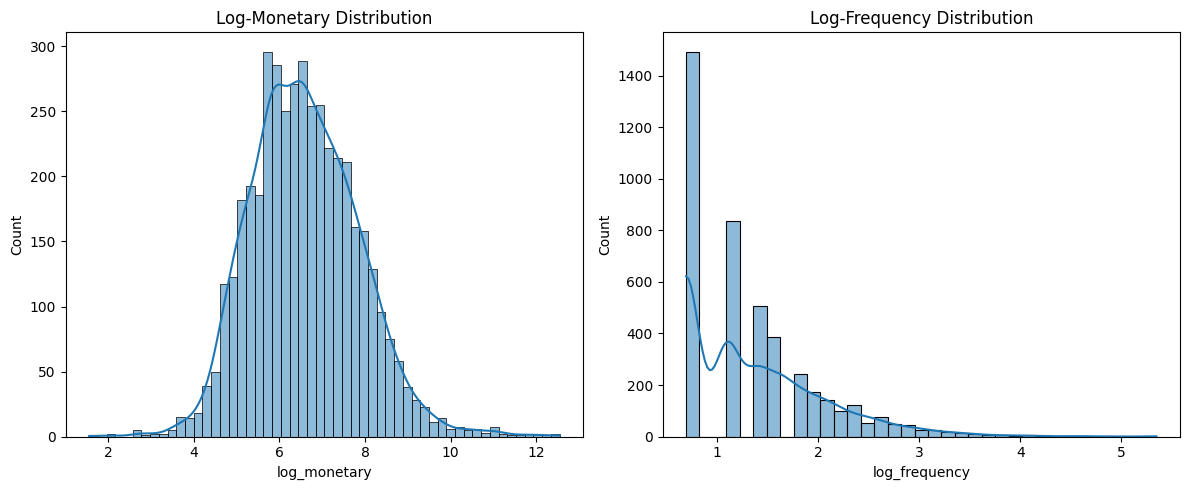


--- Descriptive Statistics of Scaled Data ---
                      count          mean       std       min       25%  \
recency              4338.0  2.702618e-17  1.000115 -0.915340 -0.745345   
avg_order_value      4338.0 -7.370775e-18  1.000115 -0.045137 -0.038144   
avg_items_per_order  4338.0  5.732825e-18  1.000115 -0.036621 -0.032465   
days_between_orders  4338.0  0.000000e+00  0.000000  0.000000  0.000000   
log_monetary         4338.0  2.882792e-16  1.000115 -4.004574 -0.685668   
log_frequency        4338.0 -7.206980e-17  1.000115 -0.955214 -0.955214   

                          50%       75%        max  
recency             -0.415353  0.494623   2.814561  
avg_order_value     -0.034493 -0.029632  52.539782  
avg_items_per_order -0.029141 -0.025263  61.638807  
days_between_orders  0.000000  0.000000   0.000000  
log_monetary        -0.062187  0.654186   4.731591  
log_frequency       -0.361583  0.653237   5.858535  


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

try:
    df = pd.read_excel('Online Retail.xlsx')
    df.columns = df.columns.str.lower()
    df.rename(columns={'invoiceno': 'invoice_no', 'stockcode': 'stock_code',
                       'invoicedate': 'invoice_date', 'unitprice': 'price',
                       'customerid': 'customer_id'}, inplace=True)
    df.dropna(subset=['customer_id'], inplace=True)
    df['customer_id'] = df['customer_id'].astype(int)
    df = df[~df['invoice_no'].astype(str).str.startswith('C')]
    df = df[(df['quantity'] > 0) & (df['price'] > 0)]
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    df.sort_values('invoice_date', inplace=True)

    df['total_spend'] = df['quantity'] * df['price']
    reference_date = df['invoice_date'].max() + pd.Timedelta(days=1)

    customer_data = df.groupby('customer_id').agg(
        recency=('invoice_date', lambda x: (reference_date - x.max()).days),
        frequency=('invoice_no', 'nunique'),
        monetary=('total_spend', 'sum'),
        avg_order_value=('total_spend', 'mean'),
        avg_items_per_order=('quantity', 'mean')
    ).reset_index()

    # re-calculate days_between_orders to handle the issue.
    # calculate the time differences for each customer and get the mean.
    customer_data['days_between_orders'] = df.groupby('customer_id')['invoice_date'].apply(
        lambda x: (x.diff().mean()).days
    )
    customer_data['days_between_orders'].fillna(0, inplace=True)

except FileNotFoundError:
    print("Local file not found. Loading from public URL.")
    pass

# identify the features for clustering
features = ['recency', 'frequency', 'monetary', 'avg_order_value', 'avg_items_per_order', 'days_between_orders']
X = customer_data[features]

# apply log transformation to skewed features
X['log_monetary'] = np.log1p(X['monetary'])
X['log_frequency'] = np.log1p(X['frequency'])
X = X.drop(columns=['monetary', 'frequency'])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(X['log_monetary'], kde=True)
plt.title('Log-Monetary Distribution')
plt.subplot(1, 2, 2)
sns.histplot(X['log_frequency'], kde=True)
plt.title('Log-Frequency Distribution')
plt.tight_layout()
plt.show()


# define the preprocessing pipeline for standard scaling
preprocessor = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# fit and transform the data using the pipeline
X_scaled = preprocessor.fit_transform(X)

# a sanity check
scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print("\n--- Descriptive Statistics of Scaled Data ---")
print(scaled_df.describe().T)

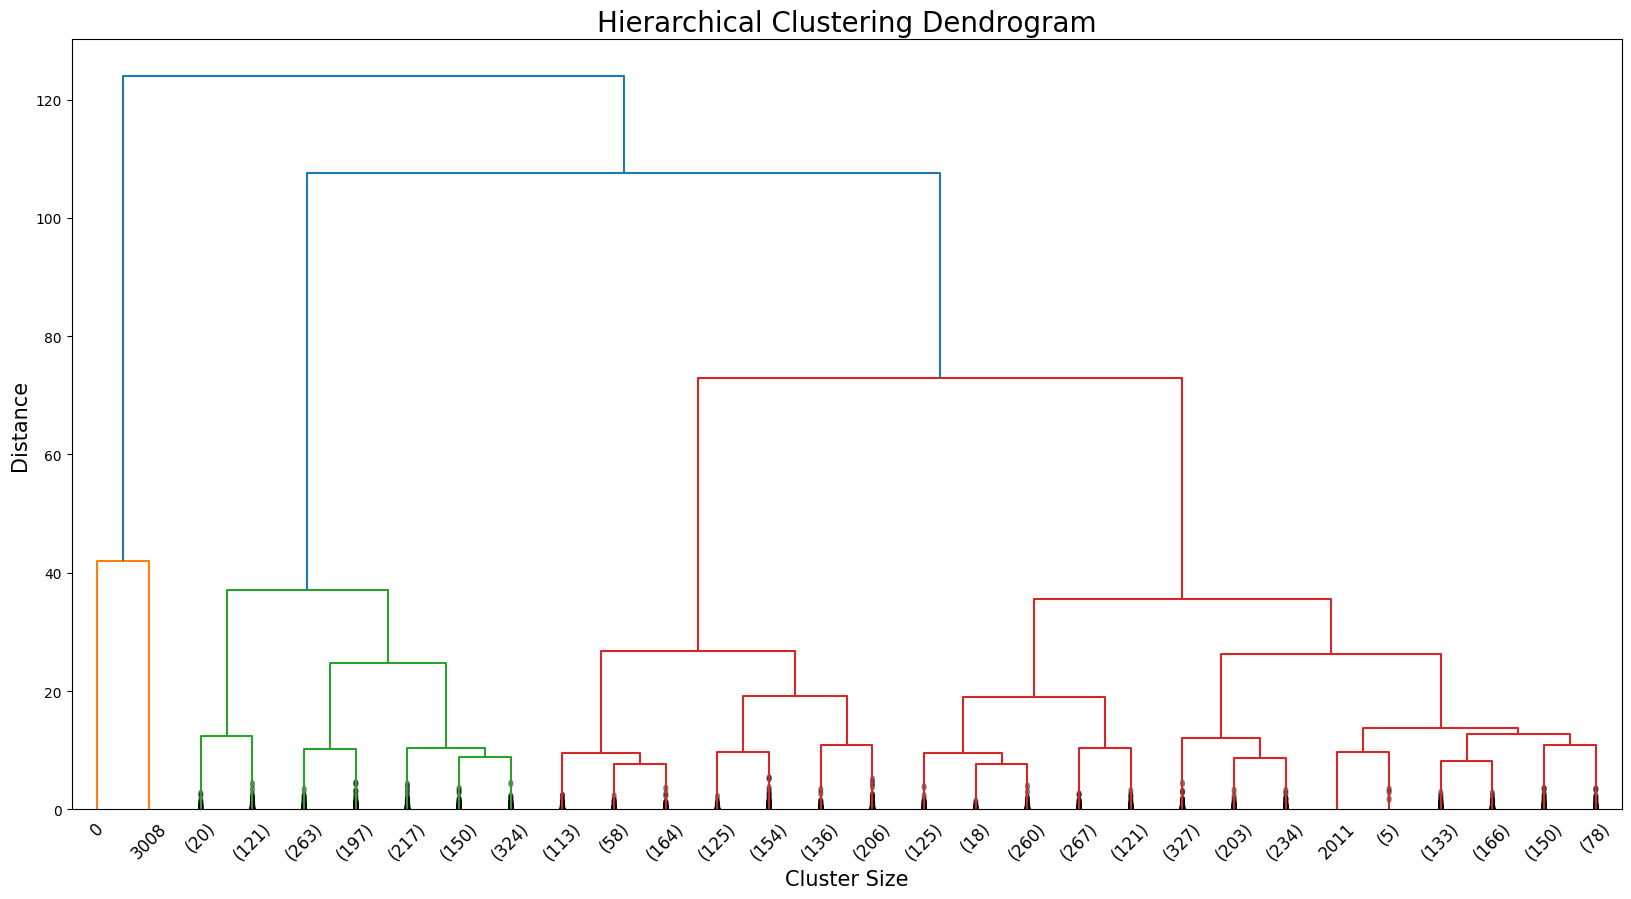

Cluster labels assigned for a placeholder k=4: [0 2 2 ... 1 2 2]


In [7]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

X_scaled = scaled_df.values

# compute the linkage matrix- use the 'ward' method, which minimizes the variance of the clusters being merged.
Z = linkage(X_scaled, method='ward', metric='euclidean')

# plot the dendrogram
plt.figure(figsize=(20, 10))
dendrogram(Z, truncate_mode='lastp', p=30, show_contracted=True, orientation='top', leaf_font_size=12)
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('Cluster Size', fontsize=15)
plt.ylabel('Distance', fontsize=15)
plt.show()

# run the AgglomerativeClustering model
n_clusters_placeholder = 4
agg_clustering_model = AgglomerativeClustering(n_clusters=n_clusters_placeholder, linkage='ward')

# predict the cluster labels
cluster_labels = agg_clustering_model.fit_predict(X_scaled)
print(f"Cluster labels assigned for a placeholder k={n_clusters_placeholder}: {cluster_labels}")

For n_clusters = 2, Silhouette Score: 0.9657
For n_clusters = 3, Silhouette Score: 0.3969
For n_clusters = 4, Silhouette Score: 0.3854
For n_clusters = 5, Silhouette Score: 0.3852
For n_clusters = 6, Silhouette Score: 0.3610
For n_clusters = 7, Silhouette Score: 0.3060
For n_clusters = 8, Silhouette Score: 0.2771
For n_clusters = 9, Silhouette Score: 0.2722
For n_clusters = 10, Silhouette Score: 0.2612


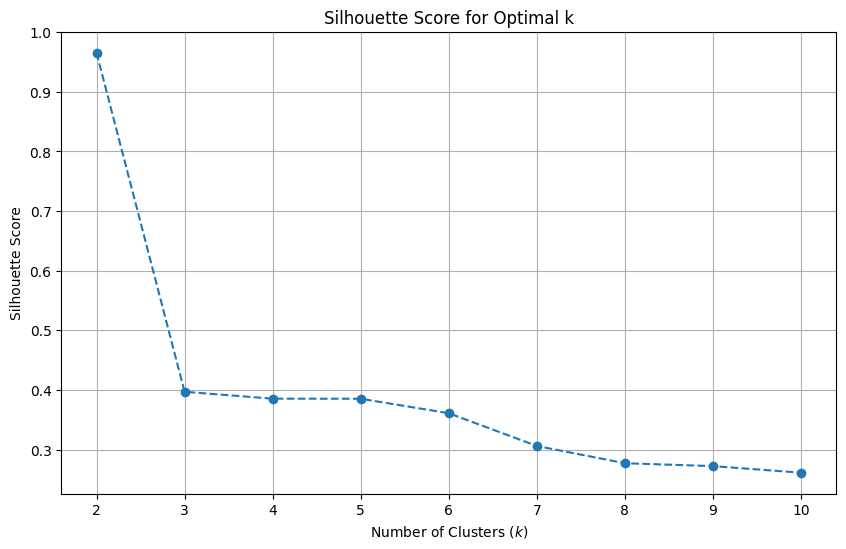

In [9]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

silhouette_scores = []

range_n_clusters = range(2, 11)

# iterate through the range of clusters and calculate the score
for n_clusters in range_n_clusters:
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)
    print(f"For n_clusters = {n_clusters}, Silhouette Score: {score:.4f}")

# plot the silhouette scores to find the optimal k
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters ($k$)')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

In [11]:
import pandas as pd
import joblib
from sklearn.cluster import AgglomerativeClustering

optimal_k = 2
final_model = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
cluster_labels = final_model.fit_predict(X_scaled)

# attach the cluster labels to the original customer data
customer_data['cluster_label'] = cluster_labels

# display the cluster counts to see the size of each segment
print("Cluster Counts:")
print(customer_data['cluster_label'].value_counts())

# persist the final model and the customer data with cluster labels
joblib.dump(final_model, 'agg_clustering_model.pkl')
customer_data.to_csv('customer_segments.csv', index=False)

Cluster Counts:
cluster_label
0    4336
1       2
Name: count, dtype: int64


Cluster Profiles (Mean and Median):
                 recency              frequency                    monetary  \
                    mean median count      mean median count           mean   
cluster_label                                                                 
0               92.50369   51.0  4336  4.273293    2.0  4336    1998.558995   
1              163.50000  163.5     2  1.500000    1.5     2  122828.050000   

                                avg_order_value                      \
                   median count            mean        median count   
cluster_label                                                         
0                 673.855  4336       37.629934     17.718418  4336   
1              122828.050     2    66670.550000  66670.550000     2   

              avg_items_per_order                      
                             mean        median count  
cluster_label                                          
0                       21.743625      9.996

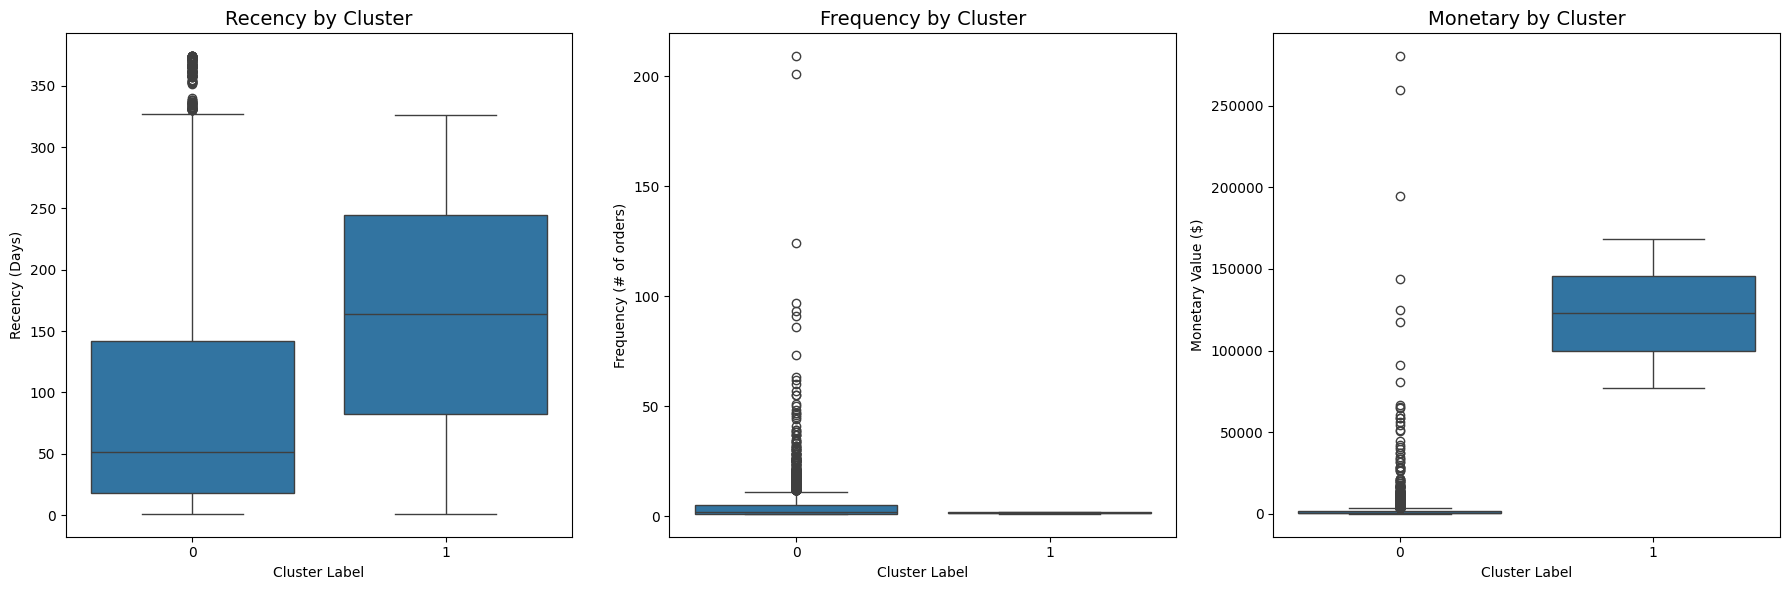

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# group by cluster to get mean and median of original features
cluster_profiles = customer_data.groupby('cluster_label')[
    ['recency', 'frequency', 'monetary', 'avg_order_value', 'avg_items_per_order']
].agg(['mean', 'median', 'count'])

print("Cluster Profiles (Mean and Median):")
print(cluster_profiles)

# boxplots of key features by cluster
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.boxplot(x='cluster_label', y='recency', data=customer_data, ax=axes[0])
axes[0].set_title('Recency by Cluster', fontsize=14)
axes[0].set_xlabel('Cluster Label')
axes[0].set_ylabel('Recency (Days)')

sns.boxplot(x='cluster_label', y='frequency', data=customer_data, ax=axes[1])
axes[1].set_title('Frequency by Cluster', fontsize=14)
axes[1].set_xlabel('Cluster Label')
axes[1].set_ylabel('Frequency (# of orders)')

sns.boxplot(x='cluster_label', y='monetary', data=customer_data, ax=axes[2])
axes[2].set_title('Monetary by Cluster', fontsize=14)
axes[2].set_xlabel('Cluster Label')
axes[2].set_ylabel('Monetary Value ($)')

plt.tight_layout()
plt.show()

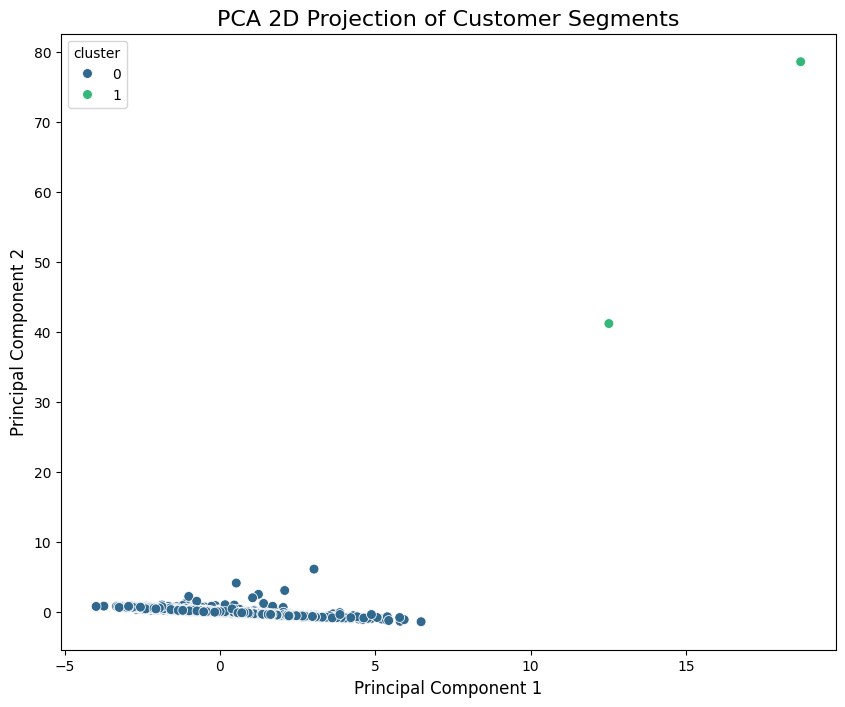

Final segmented data and model saved.


In [14]:
import pandas as pd
import joblib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# dimensionality Reduction for Visualization
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['cluster'] = customer_data['cluster_label']

# create a Scatter Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis', legend='full', s=50)
plt.title('PCA 2D Projection of Customer Segments', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.show()

# persist the model and labeled data
joblib.dump(final_model, 'agg_clustering_model.pkl')
customer_data.to_csv('customer_segments_final.csv', index=False)
print("Final segmented data and model saved.")

In [15]:
from sklearn.metrics import davies_bouldin_score
import pandas as pd

# calculate the Davies-Bouldin Score
db_score = davies_bouldin_score(X_scaled, cluster_labels)
print(f"Davies-Bouldin Score: {db_score:.4f}")


Davies-Bouldin Score: 0.3626


In [16]:
import pandas as pd
cluster_name_mapping = {
    0: "The Core Customer Base",
    1: "The Extreme High-Value Buyers"
}

customer_data['cluster_name'] = customer_data['cluster_label'].map(cluster_name_mapping)

print(customer_data[['customer_id', 'cluster_label', 'cluster_name']].head())

customer_data.to_csv('customer_segments_final.csv', index=False)

   customer_id  cluster_label                   cluster_name
0        12346              1  The Extreme High-Value Buyers
1        12347              0         The Core Customer Base
2        12348              0         The Core Customer Base
3        12349              0         The Core Customer Base
4        12350              0         The Core Customer Base
